In [ ]:
import os
import pathlib
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

import random
import IPython.display as ipd
import pandas as pd

In [ ]:
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/GuitarChords'

data_dir = pathlib.Path(DATASET_PATH)
training_dir = pathlib.Path(DATASET_PATH)
test_dir = pathlib.Path(DATASET_PATH)

chords = np.array(tf.io.gfile.listdir(str(training_dir)))
print('Chords:', chords)

Chords: ['Dm' 'Am' 'Bb' 'C' 'Bdim' 'Em' 'F' 'G']


In [ ]:
filenames = tf.io.gfile.glob(str(training_dir) + '/*/*' )
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of training examples:', num_samples)
print('Number of examples per label:', len(tf.io.gfile.listdir(str(training_dir/chords[0]))))
print('Example file tensor:', filenames[0])

Number of training examples: 1760
Number of examples per label: 220
Example file tensor: tf.Tensor(b'/content/drive/MyDrive/Colab Notebooks/GuitarChords/F/F (8).wav', shape=(), dtype=string)


In [ ]:
train_files = filenames[:1152]
val_files = filenames[-288:]
test_files = filenames[1152:-288]

print('Training set size', len(train_files))
print('Validation test size', len(val_files))
print('Test set size', len(test_files))

Training set size 1152
Validation test size 288
Test set size 320


In [ ]:
def load_and_preprocess(file_path_tensor):
    # Convert tf.Tensor to string
    file_path = file_path_tensor.numpy().decode('utf-8')

    # Load audio
    audio, orig_sr = librosa.load(file_path, sr=None)

    # Check if the sample rate is available, otherwise set a default
    if orig_sr is None:
        orig_sr = 22050  

    # Resample the audio to a fixed rate 
    target_sr = 22050
    audio = librosa.resample(audio, orig_sr=orig_sr, target_sr=target_sr)

    chromagram = librosa.feature.chroma_stft(y=audio, sr=target_sr)
    # Apply min-max normalization
    chromagram = (chromagram - np.min(chromagram)) / (np.max(chromagram) - np.min(chromagram))

    # Pad or truncate the chromagram to a fixed size 
    target_size = (12, 137)

    if chromagram.shape[1] < target_size[1]:
        # Pad if the chromagram < target size
        chromagram = np.pad(chromagram, ((0, 0), (0, target_size[1] - chromagram.shape[1])))
    elif chromagram.shape[1] > target_size[1]:
        # Truncate if the chromagram > target size
        chromagram = chromagram[:, :target_size[1]]

    return chromagram

In [ ]:
def get_label(file_path):
    parts = tf.strings.split(input=file_path, sep=os.path.sep)
    return parts[-2]

In [ ]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(
        map_func=lambda x: tf.py_function(func=load_and_preprocess, inp=[x], Tout=tf.float32),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    label_ds = files_ds.map(
        map_func=lambda x: get_label(x),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    return tf.data.Dataset.zip((output_ds, label_ds))

In [ ]:
# Split the data into training and validation sets


train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [ ]:
# Load dataset into a Pandas DataFrame for easy manipulation
data = pd.DataFrame({'path': filenames, 'label': [get_label(file) for file in filenames]})


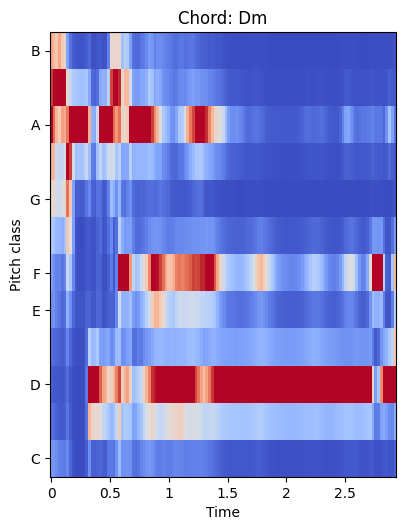

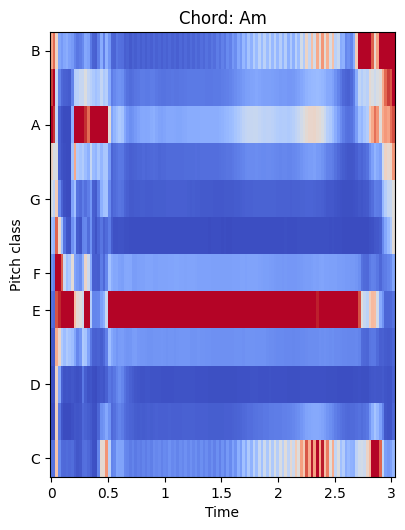

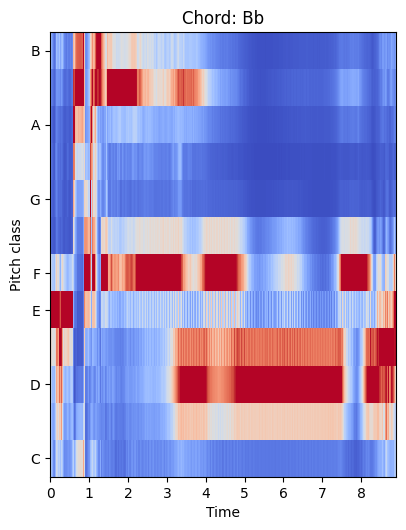

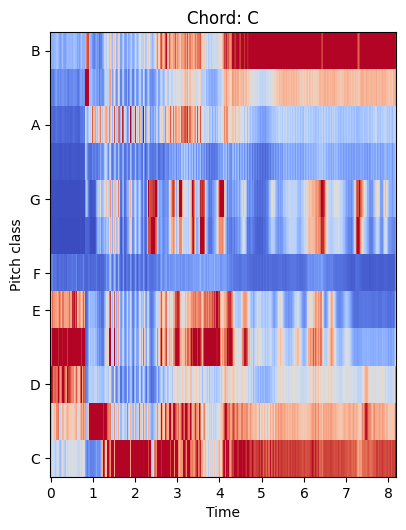

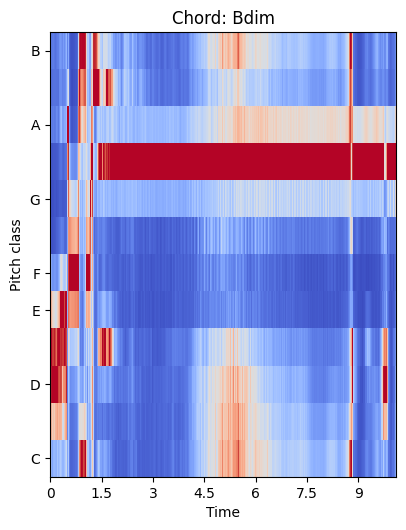

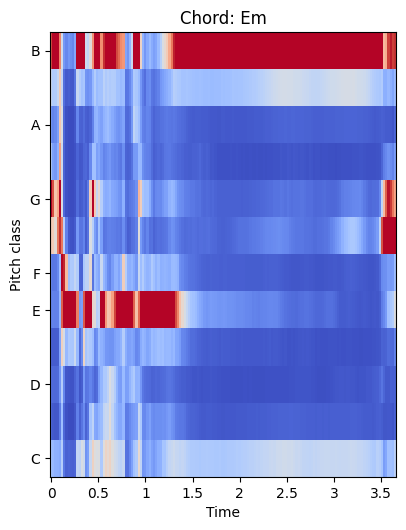

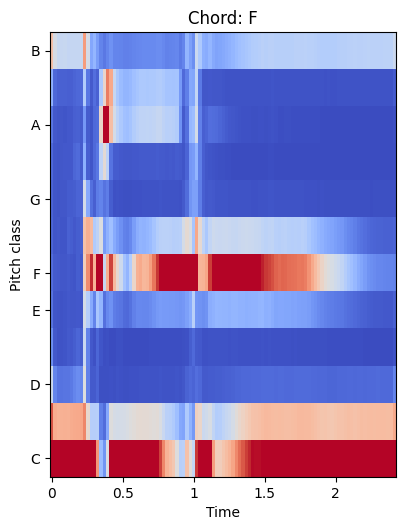

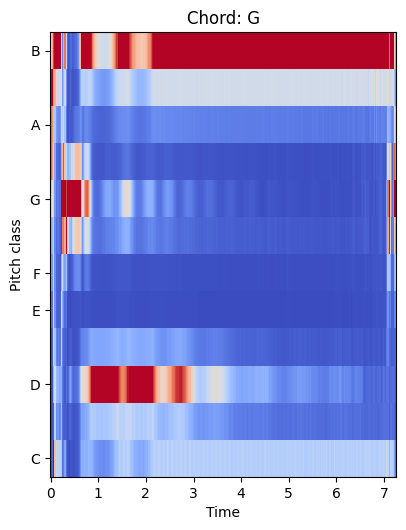

In [ ]:
# get random data from a chord category
def get_random_data(chord_label):
    chord_data = data[data['label'] == chord_label]
    # Get 8 random samples
    random_samples = chord_data.sample(1)

    plt.figure(figsize=(15, 10))
    for i, (_, row) in enumerate(random_samples.iterrows(), 1):
        plt.subplot(2, 4, i)
        # Load the audio file
        audio, sr = librosa.load(row['path'], sr=None)
        # Extract chromagram
        chromagram = librosa.feature.chroma_stft(y=audio, sr=sr)
        # Plot chromagram
        librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')
        plt.title(f'Chord: {chord_label}')
    plt.tight_layout()
    plt.show()

# Plot random samples from each chord category
for chord_label in chords:
    get_random_data(chord_label)

In [ ]:
def convert_for_training(dataset):
    data = []
    labels = []

    for chromagram, label in dataset:
        data.append(chromagram)
        labels.append(chords.tolist().index(label.numpy().decode('utf-8')))

    return np.array(data), np.array(labels)

In [ ]:
# Convert datasets for training
train_data, train_labels = convert_for_training(train_ds)
val_data, val_labels = convert_for_training(val_ds)
test_data, test_labels = convert_for_training(test_ds)

In [ ]:
# Model architecture
model = models.Sequential([
    #layers.InputLayer(input_shape=(12,137,1)),
    layers.Reshape((12, 137, 1), input_shape=(12, 137)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(chords), activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 12, 137, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 10, 135, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 67, 32)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 5, 67, 32)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 65, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 32, 64)        0         
 2D)                                                    

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

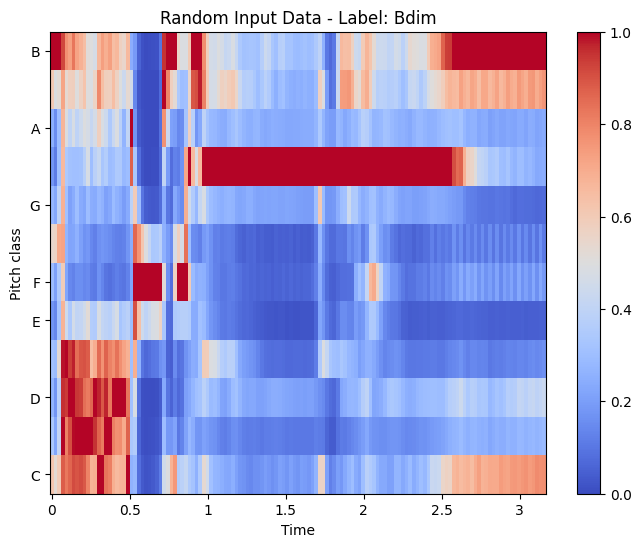

Label: Bdim


In [ ]:
#Random code to check how dataset looks before input

# Visualize a random input from the dataset before training starts
random_index = random.randint(0, len(train_data) - 1)
random_input_data = train_data[random_index]
random_label = chords[train_labels[random_index]]

# Reshape the data to match the model's input shape
random_input_data = random_input_data.reshape((1, 12, 137))

# Display the chromagram
plt.figure(figsize=(8, 6))
librosa.display.specshow(random_input_data[0].reshape((12, 137)), x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.title(f'Random Input Data - Label: {random_label}')
plt.colorbar()
plt.show()

print(f"Label: {random_label}")


In [ ]:
# Train the model
history = model.fit(train_data, train_labels,
                    epochs=50,
                    validation_data=(val_data, val_labels),
                    callbacks=[EarlyStopping(patience=2)])

Epoch 1/50
36/36 [==============================] - 3s 72ms/step - loss: 2.0140 - accuracy: 0.1892 - val_loss: 1.8243 - val_accuracy: 0.3299
Epoch 2/50
36/36 [==============================] - 2s 58ms/step - loss: 1.6036 - accuracy: 0.4210 - val_loss: 1.3296 - val_accuracy: 0.5417
Epoch 3/50
36/36 [==============================] - 2s 59ms/step - loss: 1.1302 - accuracy: 0.6224 - val_loss: 0.9086 - val_accuracy: 0.7049
Epoch 4/50
36/36 [==============================] - 2s 62ms/step - loss: 0.8507 - accuracy: 0.7127 - val_loss: 0.6684 - val_accuracy: 0.8090
Epoch 5/50
36/36 [==============================] - 4s 101ms/step - loss: 0.6885 - accuracy: 0.7786 - val_loss: 0.6016 - val_accuracy: 0.8229
Epoch 6/50
36/36 [==============================] - 3s 95ms/step - loss: 0.5992 - accuracy: 0.8151 - val_loss: 0.6021 - val_accuracy: 0.8194
Epoch 7/50
36/36 [==============================] - 4s 103ms/step - loss: 0.5203 - accuracy: 0.8394 - val_loss: 0.5306 - val_accuracy: 0.8403
Epoch 8/50


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

10/10 [==============================] - 0s 15ms/step - loss: 0.3464 - accuracy: 0.9000
Test Accuracy: 90.00%


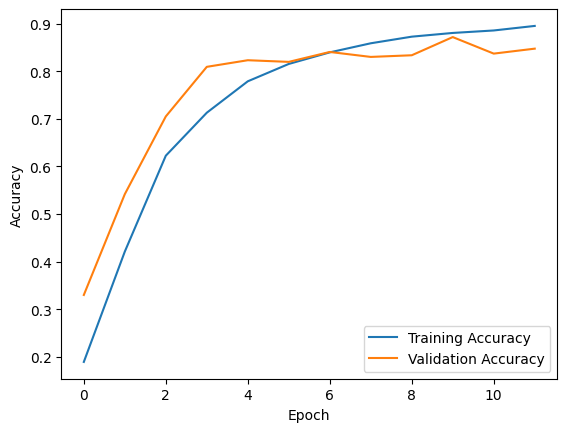

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

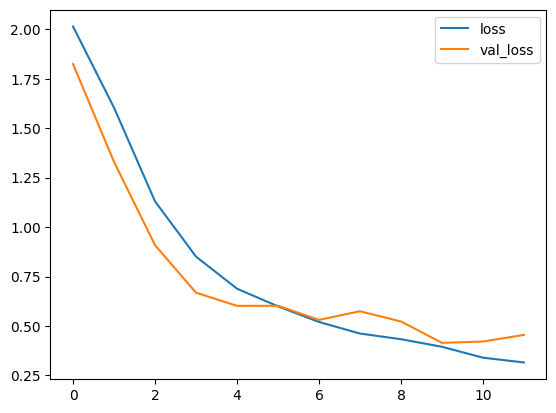

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

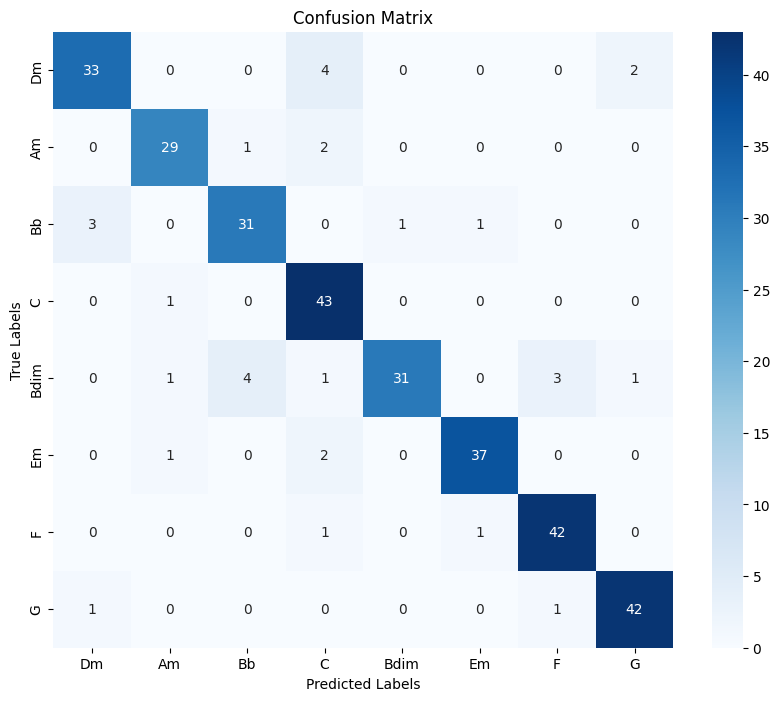

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict labels for the test set
predicted_labels = model.predict(test_data)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Create a confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=chords, yticklabels=chords)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

True Label: Em
Predicted Label: Em


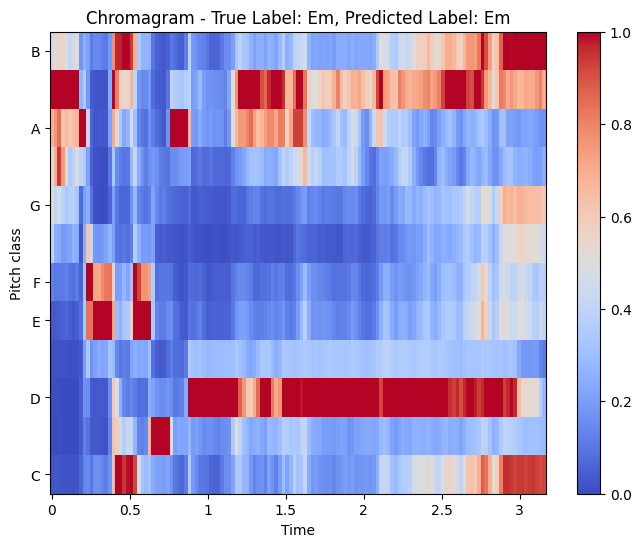

In [ ]:
import random

# Randomly select an index from the preprocessed test set
random_index = random.randint(0, len(test_data) - 1)
random_audio_data = test_data[random_index]
random_true_label = chords[test_labels[random_index]]

# Reshape the data to match the model's input shape
random_audio_data = random_audio_data.reshape((1, 12, 137))

# Predict the label using the trained model
predicted_label_index = np.argmax(model.predict(random_audio_data))
predicted_label = chords[predicted_label_index]

# Display the results
print(f"True Label: {random_true_label}")
print(f"Predicted Label: {predicted_label}")

# Plot the chromagram
plt.figure(figsize=(8, 6))
librosa.display.specshow(random_audio_data[0].reshape((12, 137)), x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.title(f'Chromagram - True Label: {random_true_label}, Predicted Label: {predicted_label}')
plt.colorbar()
plt.show()


In [ ]:
# Save the trained model
model.save("/content/drive/MyDrive/Colab Notebooks/guitar_spectrogram_90")

# Optional: Save the scaler (if used during preprocessing)
# scaler.save("/content/drive/MyDrive/Colab Notebooks/chord_scaler")

print("Model and scaler saved successfully.")

Model and scaler saved successfully.


In [ ]:


import librosa
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("/content/drive/MyDrive/Colab Notebooks/guitar_chord_model_spectrogram")

# Load the audio file
audio_path = '/content/drive/MyDrive/Colab Notebooks/Testing the model/Felectric.wav' 
audio, sr = librosa.load(audio_path, sr=None)

# Convert audio to chromagram
target_sr = 22050
audio_resampled = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
chromagram = librosa.feature.chroma_stft(y=audio_resampled, sr=target_sr)

# Apply min-max normalization
chromagram = (chromagram - np.min(chromagram)) / (np.max(chromagram) - np.min(chromagram))

# Pad or truncate the chromagram to match the model input shape
target_size = (12, 137)
if chromagram.shape[1] < target_size[1]:
    chromagram = np.pad(chromagram, ((0, 0), (0, target_size[1] - chromagram.shape[1])))
elif chromagram.shape[1] > target_size[1]:
    chromagram = chromagram[:, :target_size[1]]

# Reshape to match the model input shape
chromagram_reshaped = chromagram.reshape((1, 12, 137, 1))

# Predict chord using the trained model
predicted_label_index = np.argmax(model.predict(chromagram_reshaped))
predicted_chord = chords[predicted_label_index]

# Display the results
print(f"Predicted Chord: {predicted_chord}")


1/1 [==============================] - 0s 122ms/step
Predicted Chord: F
